downlaod from fashion MNIST  
```
wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz
```
put them into data/fashion

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./data/fashion', one_hot=True)

Extracting ./data/fashion/train-images-idx3-ubyte.gz
Extracting ./data/fashion/train-labels-idx1-ubyte.gz
Extracting ./data/fashion/t10k-images-idx3-ubyte.gz
Extracting ./data/fashion/t10k-labels-idx1-ubyte.gz


In [3]:
img, label = mnist.train.next_batch(10)

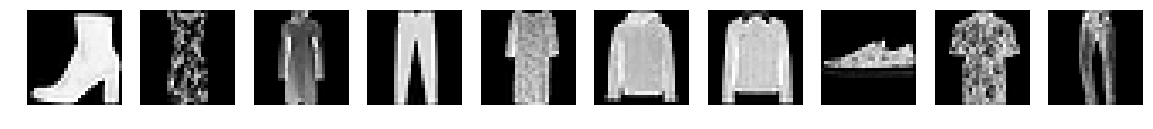

In [4]:
dim = 28
fig, axs = plt.subplots(1, len(img), figsize=(20, 3))
for i, m in enumerate(img):
        axs[i].imshow(np.reshape(m, (dim, dim)),cmap='gray')
        axs[i].axis('off')
plt.show()

In [5]:
def weight_variable(shape):
    w = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(w)

def bias_variable(shape):
    b = tf.constant(0.1, shape=shape)
    return tf.Variable(b)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def variable_summaries(var):
   
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [22]:
height = 28
width = 28
image_size = height * width
log_dir = "logs"
g1 = None

with tf.Graph().as_default() as g1:
    with tf.name_scope('input'):
        x = tf.placeholder(tf.float32, shape=[None, image_size], name='x-input')
        y_ = tf.placeholder(tf.float32, shape=[None, 10], name='y-input')

    with tf.name_scope('input_reshape'):    
        x_image = tf.reshape(x, [-1, height, width, 1])
        tf.summary.image('input',  x_image, 10)

    with tf.name_scope("conv1"):
        with tf.name_scope('weights'):
            W_conv1 = weight_variable([5,5,1,32])
            variable_summaries(W_conv1)        
        with tf.name_scope('biases'):
            b_conv1 = bias_variable([32])
            variable_summaries(b_conv1)
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
        variable_summaries(h_conv1)
    
    with tf.name_scope("pool1"):   
        h_pool1 = max_pool_2x2(h_conv1)

    with tf.name_scope("conv2"):
        with tf.name_scope('weights'):
            W_conv2 = weight_variable([5,5,32,64])
        with tf.name_scope('biases'):    
            b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    with tf.name_scope("pool2"):
        h_pool2 = max_pool_2x2(h_conv2)
    
    with tf.name_scope("pool2_flat"):
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    
    with tf.name_scope("fc1"):
        with tf.name_scope('weights'):
            W_fc1 = weight_variable([7 * 7 * 64, 1024])
        with tf.name_scope('biases'):   
            b_fc1 = bias_variable([1024])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    with tf.name_scope("dropout"):
        keep_prob = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    with tf.name_scope("fc2"):
        W_fc2 = weight_variable([1024,10])
        b_fc2 = bias_variable([10])
        y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    with tf.name_scope("loss"):
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
        tf.summary.scalar('cross_entropy', loss)

    with tf.name_scope("optimizer"):
        opt = tf.train.AdamOptimizer(1e-4).minimize(loss)

    with tf.name_scope("accuracy"):
        correct = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        tf.summary.scalar('accuracy', accuracy)

In [23]:
import tensorboard as tb 
tb.show_graph(g1)

In [9]:
if tf.gfile.Exists(log_dir):
    tf.gfile.DeleteRecursively(log_dir)
tf.gfile.MakeDirs(log_dir)

with tf.Session(graph=g1) as sess:
    sess.run(tf.global_variables_initializer())
    
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/test')
    
    for i in range(50000):
        batch = mnist.train.next_batch(50)
        _ = sess.run(opt, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
        
        if i % 100 == 0:
            train_loss, train_accuracy, summary = sess.run([loss, accuracy, merged], feed_dict={
                  x: batch[0], y_: batch[1], keep_prob: 1.0})
            print('step %d, training loss %g, training accuracy %g' % (i, train_loss, train_accuracy))
            train_writer.add_summary(summary, i)
        
    test_accuracy, test_summary = sess.run([accuracy, merged], 
                                           feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
    train_writer.add_summary(test_summary, 0)
    print('test accuracy %g' % test_accuracy)

step 0, training loss 5.76624, training accuracy 0.12
step 100, training loss 0.646952, training accuracy 0.76
step 200, training loss 0.714204, training accuracy 0.78
step 300, training loss 0.528768, training accuracy 0.8
step 400, training loss 0.475609, training accuracy 0.78
step 500, training loss 0.441702, training accuracy 0.82
step 600, training loss 0.715665, training accuracy 0.76
step 700, training loss 0.342492, training accuracy 0.92
step 800, training loss 0.439231, training accuracy 0.88
step 900, training loss 0.210543, training accuracy 0.96
step 1000, training loss 0.281087, training accuracy 0.9
step 1100, training loss 0.288505, training accuracy 0.88
step 1200, training loss 0.517196, training accuracy 0.82
step 1300, training loss 0.595132, training accuracy 0.84
step 1400, training loss 0.335426, training accuracy 0.82
step 1500, training loss 0.220689, training accuracy 0.94
step 1600, training loss 0.282994, training accuracy 0.9
step 1700, training loss 0.484

# Visualization

In [31]:
from tensorflow.contrib.tensorboard.plugins import projector
X = mnist.test.images
Y = mnist.test.labels
LOG_DIR = os.path.join(os.getcwd(), log_dir, 'visualization')
if tf.gfile.Exists(LOG_DIR):
    tf.gfile.DeleteRecursively(LOG_DIR)
tf.gfile.MakeDirs(LOG_DIR)

In [32]:
labels = ['t_shirt_top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']
with open(os.path.join(LOG_DIR, 'metadata.tsv'),'w') as f:
    f.write("Index\tLabel\n")
    for index, label in enumerate(mnist.test.labels):
        f.write("%d\t%s\n" % (index, labels[np.argmax(label)]))

In [33]:
rows =[]
columns = []
 

for img in mnist.test.images:
    img_ = 255 - np.reshape(img, [28, 28]) # invert grayscale 
    rows.append(img_)

for i in range(100):
    columns.append(np.concatenate(rows[100*i:100*(i+1)], axis=1))
    
images = np.concatenate(columns, axis=0)
from scipy import misc
misc.imsave(os.path.join(LOG_DIR, 'sprite.png'), images)

In [34]:
labels = ['t_shirt_top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']

embedding_var = tf.Variable(X, name='mnist_pixels')
config = projector.ProjectorConfig()

embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name
embedding.metadata_path = os.path.join(LOG_DIR, 'metadata.tsv')
embedding.sprite.image_path = os.path.join(LOG_DIR,  'sprite.png')
embedding.sprite.single_image_dim.extend([28, 28])

summary_writer = tf.summary.FileWriter(LOG_DIR)
projector.visualize_embeddings(summary_writer, config)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.save(sess, os.path.join(LOG_DIR,  'model.ckpt'), 0)

```
tensorboard --logdir=logs/visualization/
```